# AI Tools for Actuaries
## Chapter 5: LocalGLMnet in Python - PyTorch
### Author: Marco Maggi, Mario Wuthrich
### Version August 2025

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import glm

pd.options.mode.chained_assignment = None

# Set random seed
rng = np.random.default_rng(500)

### Load data

In [2]:
# Load the data (load the data with the entity embeddings)
df = pd.read_parquet("../../Data/freMTPL2freqEmb.parquet")
df.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,LearnTest,VehBrandEmb1,VehBrandEmb2,RegionEmb1,RegionEmb2
0,4156370.0,0.06,D,6,6,20,100,B2,Regular,525,R82,0.0,0.0,L,0.044015,0.035447,-0.152247,0.118482
1,4006798.0,0.29,E,6,7,29,59,B12,Diesel,2498,R72,0.0,0.0,L,-0.330465,-0.310052,-0.084036,0.029946
2,6084964.0,0.46,C,7,10,27,68,B1,Diesel,123,R82,0.0,0.0,L,0.035448,0.022551,-0.152247,0.118482
3,2228865.0,0.08,D,4,15,34,50,B2,Regular,1109,R24,0.0,0.0,L,0.044015,0.035447,0.042393,0.143507
4,4141911.0,1.00,A,5,22,44,50,B3,Diesel,34,R72,0.0,0.0,L,0.048288,0.070531,-0.084036,0.029946


In [3]:
# Add random component
df["RandN"] = rng.normal(0, 1, size=len(df))

In [4]:
learn = df[df["LearnTest"] == "L"]
test = df[df["LearnTest"] == "T"]

### Pre-process data for LocalGLMnet

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OrdinalEncoder,
    StandardScaler,
)


def clip_and_scale(upper):
    pipe = Pipeline(
        steps=[
            ("clip", FunctionTransformer(lambda x: np.clip(x, a_min=0, a_max=upper))),
            ("scale", StandardScaler()),
        ]
    )
    return pipe


density = Pipeline(
    steps=[
        ("log", FunctionTransformer(lambda x: np.log(x).round(2))),
        ("scale", StandardScaler()),
    ]
)

area = Pipeline(
    steps=[
        ("encode", OrdinalEncoder()),
        ("scale", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        (
            "clip_and_scale",
            clip_and_scale([20, 90, 150, 15]),
            ["VehAge", "DrivAge", "BonusMalus", "VehPower"],
        ),
        (
            "scale",
            StandardScaler(),
            ["RegionEmb1", "RegionEmb2", "VehBrandEmb1", "VehBrandEmb2"],
        ),
        ("area", area, ["Area"]),
        ("density", density, ["Density"]),
        (
            "veh_gas",
            FunctionTransformer(lambda x: (x == "Diesel").astype(np.float32)),
            ["VehGas"],
        ),
        ("veh_brand", OrdinalEncoder(), ["VehBrand", "Region"]),
        ("passthrough", "passthrough", ["RandN", "ClaimNb"]),
    ],
    verbose_feature_names_out=False,
)


# Just a check: Fit preprocessor to training data and apply to some lines from test
preprocessor.set_output(transform="pandas").fit(learn)
preprocessor.transform(test.head())


,VehAge,DrivAge,BonusMalus,VehPower,RegionEmb1,RegionEmb2,VehBrandEmb1,VehBrandEmb2,Area,Density,VehGas,VehBrand,Region,RandN,ClaimNb
610206,-1.29173,-1.309026,1.937902,-1.196789,-0.669207,0.058418,-1.697408,-1.70271,0.513423,0.298236,0.0,3.0,14.0,0.561822,0.0
610207,-1.29173,-0.884378,2.578711,-0.709264,0.251577,-0.276886,-1.697408,-1.70271,0.513423,0.795155,0.0,3.0,0.0,0.680472,0.0
610208,-1.29173,-0.884378,2.578711,-0.709264,0.251577,-0.276886,-1.697408,-1.70271,0.513423,0.795155,0.0,3.0,0.0,0.734685,0.0
610209,-1.29173,1.663510,-0.497176,-0.709264,0.251577,-0.276886,-1.697408,-1.70271,0.513423,0.666918,0.0,3.0,0.0,0.478952,0.0
610210,-1.29173,0.460341,-0.625338,-0.709264,-1.077756,-0.741767,-1.697408,-1.70271,-0.209473,-0.476529,0.0,3.0,20.0,1.486579,0.0


In [6]:
print(f"Learning set size: {len(learn)}")
print(f"Test set size: {len(test)}")

Learning set size: 610206
Test set size: 67801


In [7]:
X_learn = preprocessor.fit_transform(learn)
X_learn.head(3)

,VehAge,DrivAge,BonusMalus,VehPower,RegionEmb1,RegionEmb2,VehBrandEmb1,VehBrandEmb2,Area,Density,VehGas,VehBrand,Region,RandN,ClaimNb
0,-0.180703,-1.804449,2.578711,-0.221740,-1.371648,0.632939,0.454770,0.657292,0.513423,0.148627,0.0,6.0,17.0,0.697935,0.0
1,0.004468,-1.167477,-0.048609,-0.221740,-0.669207,0.058418,-1.697408,-1.702710,1.236318,0.982167,1.0,3.0,14.0,-0.867463,0.0
2,0.559981,-1.309026,0.528120,0.265784,-1.371648,0.632939,0.405534,0.569199,-0.209473,-0.626139,1.0,0.0,17.0,-0.288084,0.0


### GLM baseline analysis

In [8]:
# We start with a baseline GLM to initialize the LocalGLMnet suitably

# Features
features = [
    "Area",
    "VehPower",
    "VehAge",
    "DrivAge",
    "BonusMalus",
    "VehGas",
    "Density",
    "VehBrandEmb1",
    "VehBrandEmb2",
    "RegionEmb1",
    "RegionEmb2",
    "RandN",
]

# Fit GLM
model = glm(
    "ClaimNb ~ Area + VehPower + VehAge + DrivAge + BonusMalus + VehGas + Density + "
    "VehBrandEmb1 + VehBrandEmb2 + RegionEmb1 + RegionEmb2 + RandN",
    data=X_learn,
    offset=np.log(learn["Exposure"]),
    family=sm.families.Poisson(),
)

glm_results = model.fit()

# Display model summary
glm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                ClaimNb   No. Observations:               610206
Model:                            GLM   Df Residuals:                   610193
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -96590.
Date:                Mon, 04 Aug 2025   Deviance:                   1.4753e+05
Time:                        09:23:31   Pearson chi2:                 1.02e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01031
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.7540      0.010   -279.888      0.000      -2.773      -2.735
Area             0.0553      0.028      2.006      0.045       0.001       0.109
VehPower         0.0651      0.007      9.684      0.000       0.052       0.078
VehAge          -0.0967      0.007    -12.915      0.000      -0.111      -0.082
DrivAge          0.0828      0.007     12.014      0.000       0.069       0.096
BonusMalus       0.4159      0.006     72.955      0.000       0.405       0.427
VehGas           0.1742      0.013     13.063      0.000       0.148       0.200
Density          0.0832      0.027      3.047      0.002       0.030       0.137
VehBrandEmb1     0.1183      0.014      8.215      0.000       0.090       0.146
VehBrandEmb2     0.0303      0.015      2.057      0.040       0.001       0.059
RegionEmb1      -0.0895      0.007    -12.158      0.000      -0.104      -0.075
RegionEmb2       0.0167      0.008      2.112      0.035       0.001       0.032
RandN           -0.0024      0.006     -0.370      0.711      -0.015       0.010
================================================================================
"""

### Calculate deviance losses

In [9]:
X_test = preprocessor.transform(test)

In [10]:
from sklearn.metrics import mean_poisson_deviance

# Get predictions
learn["GLM"] = glm_results.predict(X_learn)
test["GLM"] = glm_results.predict(X_test)

# Calculate in-sample and out-of-sample deviance
learn_deviance = 100 * mean_poisson_deviance(
    learn["ClaimNb"] / learn["Exposure"], learn["GLM"], sample_weight=learn["Exposure"]
)
test_deviance = 100 * mean_poisson_deviance(
    test["ClaimNb"] / test["Exposure"], test["GLM"], sample_weight=test["Exposure"]
)

print("Deviance Losses:")
print(f"Learning sample: {learn_deviance:.3f}")
print(f"Test sample: {test_deviance:.3f}")

Deviance Losses:
Learning sample: 45.761
Test sample: 45.633


## LocalGLMnet
We have performed all the preparatory work above, and now we dive into the LocalGLMnet

### Define the LocalGLMnet arichtecture (of depth 3)

In [11]:
import torch
from torch import nn
from torch.nn import init


class FNN(nn.Module):
    def __init__(self, seed, n_features, hidden_layers, intercept, glm_coefs):
        super().__init__()
        torch.manual_seed(seed)
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_layers)):
            if i == 0:
                self.hidden_layers.append(nn.Linear(n_features, hidden_layers[i]))
            else:
                self.hidden_layers.append(
                    nn.Linear(hidden_layers[i - 1], hidden_layers[i])
                )
        self.local_glm = nn.Linear(hidden_layers[-1], n_features)
        self.local_glm.bias.data = torch.tensor(glm_coefs, dtype=torch.float32)
        init.constant_(self.local_glm.weight, 0.0)
        self.intercept = nn.Parameter(torch.tensor(intercept, dtype=torch.float32))

    def forward(self, design, v, get_attentions=False):
        x = torch.tanh(self.hidden_layers[0](design))
        for layer in self.hidden_layers[1:]:
            x = torch.tanh(layer(x))
        x = self.local_glm(x)
        if get_attentions:
            return x
        skip_connection = torch.einsum("ij,ij->i", x, design).unsqueeze(1)
        x = self.intercept + skip_connection
        return torch.exp(x).flatten() * v


SEED = 21456783
M_FEAT = len(features)  # number of features
HIDDEN = [20, 15, 10]
mu_hom = learn.ClaimNb.sum() / learn.Exposure.sum()  # homogeneous frequency
# Create model with three hidden layers
model = FNN(
    SEED,
    n_features=M_FEAT,
    hidden_layers=HIDDEN,
    intercept=glm_results.params.iloc[0],
    glm_coefs=glm_results.params.to_numpy()[1:],
)


### Prepare the features and introduce the LocalGLMnet

### Initialize the LocalGLMnet to the previously fitted GLM

In [12]:
# Backtest the initalization
model.eval()
X_test_tensor = torch.tensor(X_test[features].values, dtype=torch.float32)
X_learn_tensor = torch.tensor(X_learn[features].values, dtype=torch.float32)
exposure_test_tensor = torch.tensor(
    test["Exposure"].astype("float32").values, dtype=torch.float32
)
exposure_learn_tensor = torch.tensor(
    learn["Exposure"].astype("float32").values, dtype=torch.float32
)

test_GLM = model(X_test_tensor, exposure_test_tensor).detach().numpy()
learn_GLM = model(X_learn_tensor, exposure_learn_tensor).detach().numpy()

# Exposure
V_learn = learn["Exposure"]
V_test = test["Exposure"]

# Response
Y_learn = learn["ClaimNb"]
Y_test = test["ClaimNb"]

poisson_deviance_train_glm = 100 * mean_poisson_deviance(
    Y_learn / V_learn, learn_GLM / V_learn, sample_weight=V_learn
)
poisson_deviance_test_glm = 100 * mean_poisson_deviance(
    Y_test / V_test, test_GLM / V_test, sample_weight=V_test
)
print(
    "Poisson Deviance (Train, Test):",
    round(poisson_deviance_train_glm, 3),
    round(poisson_deviance_test_glm, 3),
)

Poisson Deviance (Train, Test): 45.761 45.633


### Train the LocalGLMnet model

In [13]:
def train_model(
    model,
    X_train,
    y_train,
    v_train,
    X_val,
    y_val,
    v_val,
    optimizer,
    checkpoint_path,
    batch_size,
    n_epochs=100,
):
    loss_fn = nn.PoissonNLLLoss(log_input=False, reduction="sum")
    best_val_loss = float("inf")
    history = {"loss": [], "val_loss": []}

    # Create dataset indices for batching
    num_batches = (len(X_train) + batch_size - 1) // batch_size

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        # Indices can be shuffled for each epoch. We don't do it here.
        indices = torch.arange(len(X_train))

        for i in range(num_batches):
            # Get batch indices
            batch_indices = indices[
                i * batch_size : min((i + 1) * batch_size, len(X_train))
            ]

            # Get batch data
            X_batch = X_train[batch_indices]
            v_batch = v_train[batch_indices]
            y_batch = y_train[batch_indices]

            # Forward pass
            pred_batch = model(X_batch, v_batch)
            loss = loss_fn(pred_batch, y_batch)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Average loss for the epoch
        epoch_loss /= v_train.sum().item()
        history["loss"].append(epoch_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            pred_val = model(X_val, v_val)
            val_loss = (loss_fn(pred_val, y_val) / v_val.sum()).item()
            history["val_loss"].append(val_loss)

        # Save best model
        if val_loss < best_val_loss and isinstance(checkpoint_path, str):
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}"
            )
    return history


In [14]:
from sklearn.model_selection import train_test_split

convert_to_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
train, val = train_test_split(learn, test_size=0.1, random_state=125548)

X_learn = convert_to_tensor(preprocessor.transform(learn)[features])
X_train = convert_to_tensor(preprocessor.transform(train)[features])
X_val = convert_to_tensor(preprocessor.transform(val)[features])
X_test = convert_to_tensor(preprocessor.transform(test)[features])

y_learn, v_learn = convert_to_tensor(learn.ClaimNb), convert_to_tensor(learn.Exposure)
y_train, v_train = convert_to_tensor(train.ClaimNb), convert_to_tensor(train.Exposure)
y_val, v_val = convert_to_tensor(val.ClaimNb), convert_to_tensor(val.Exposure)
y_test, v_test = convert_to_tensor(test.ClaimNb), convert_to_tensor(test.Exposure)


In [15]:
optimizer = torch.optim.NAdam(model.parameters())
checkpoint_path = f"./Networks/LocalGLMnet_{SEED}.pt"
history = train_model(
    model,
    X_train,
    y_train,
    v_train,
    X_val,
    y_val,
    v_val,
    optimizer,
    checkpoint_path,
    batch_size=5_000,
    n_epochs=100,
)


Epoch 10/100, Loss: 0.2936, Val Loss: 0.2944
Epoch 20/100, Loss: 0.2931, Val Loss: 0.2944
Epoch 30/100, Loss: 0.2928, Val Loss: 0.2944
Epoch 40/100, Loss: 0.2925, Val Loss: 0.2944
Epoch 50/100, Loss: 0.2924, Val Loss: 0.2945
Epoch 60/100, Loss: 0.2922, Val Loss: 0.2946
Epoch 70/100, Loss: 0.2921, Val Loss: 0.2947
Epoch 80/100, Loss: 0.2919, Val Loss: 0.2948
Epoch 90/100, Loss: 0.2918, Val Loss: 0.2949
Epoch 100/100, Loss: 0.2917, Val Loss: 0.2950


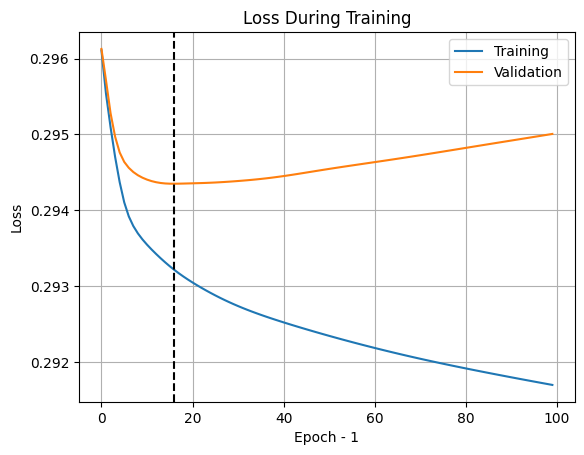

In [16]:
# Plot training history (vertical line at best validation loss)
fig = (
    pd.DataFrame({"loss": history["loss"], "val_loss": history["val_loss"]})
    .rename(columns={"loss": "Training", "val_loss": "Validation"})
    .plot(xlabel="Epoch - 1", ylabel="Loss", title="Loss During Training", grid=True)
)
_ = fig.axvline(np.argmin(history["val_loss"]), color="black", linestyle="--")


### LocalGLMnet results

In [17]:
from sklearn.metrics import mean_poisson_deviance


# Helper functions to evaluate the model via average Poisson deviance
def score(model, X, y, v):
    """Evaluate the model using sklearn's mean_poisson_deviance."""
    pred = model(X, v).detach().numpy()
    return 100 * mean_poisson_deviance(
        y.detach().numpy() / v, pred / v, sample_weight=v
    )


# Load best weights and evaluate
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

print("===GLM===")
print(
    "Poisson Deviance (Train, Test):",
    round(poisson_deviance_train_glm, 3),
    round(poisson_deviance_test_glm, 3),
)
print("===LocalGLMnet===")
print(f"Poisson Deviance (Learn): {score(model, X_learn, y_learn, v_learn):.3f}")
print(f"Poisson Deviance (Test): {score(model, X_test, y_test, v_test):.3f}")

===GLM===
Poisson Deviance (Train, Test): 45.761 45.633
===LocalGLMnet===
Poisson Deviance (Learn): 45.042
Poisson Deviance (Test): 45.028


### Illustrate the LocalGLMnet results: extract attention weights

In [18]:
attention_weights = model(X_test, v_test, get_attentions=True).detach().numpy()
attention_df = pd.DataFrame(attention_weights, columns=features)

### Boxplot of the attention weights (RandNX is unrelated to the response)

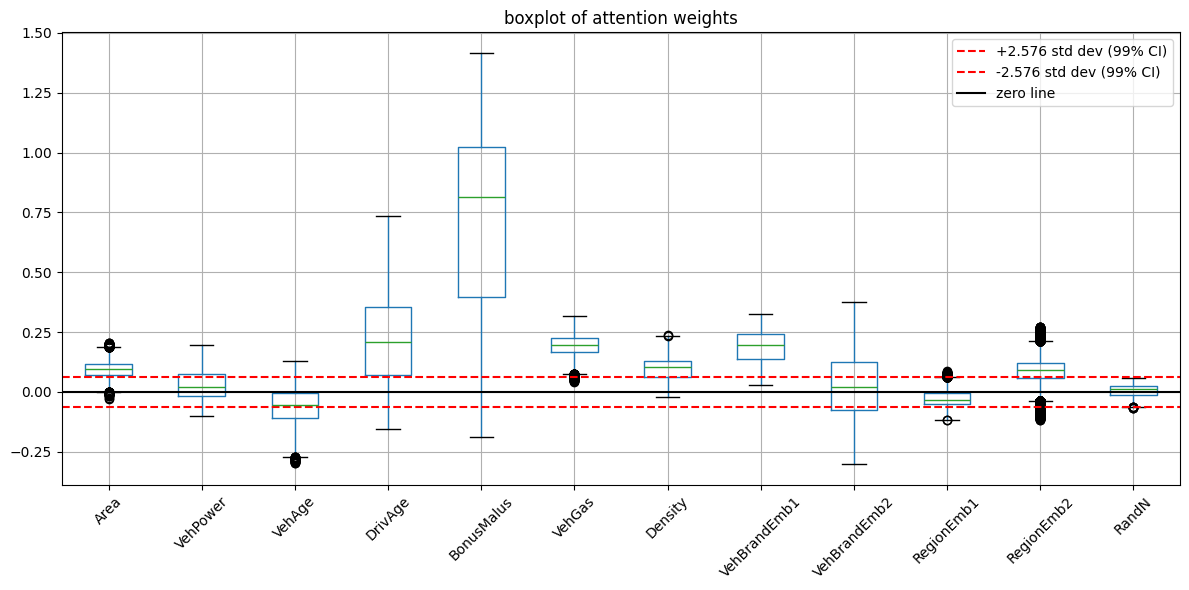

In [19]:
# Calculate standard deviation of RandNX (which does not impact the response)
randnx_std = attention_df["RandN"].std()
threshold = 2.576 * randnx_std

# Plot attention weights
plt.figure(figsize=(12, 6))
attention_df.boxplot()
plt.xticks(rotation=45)
plt.title("boxplot of attention weights")
plt.axhline(y=threshold, color="r", linestyle="--", label="+2.576 std dev (99% CI)")
plt.axhline(y=-threshold, color="r", linestyle="--", label="-2.576 std dev (99% CI)")
plt.axhline(y=0, color="k", linestyle="-", label="zero line")
plt.legend()
plt.tight_layout()
plt.show()

### Compute importance measure for all variables/terms

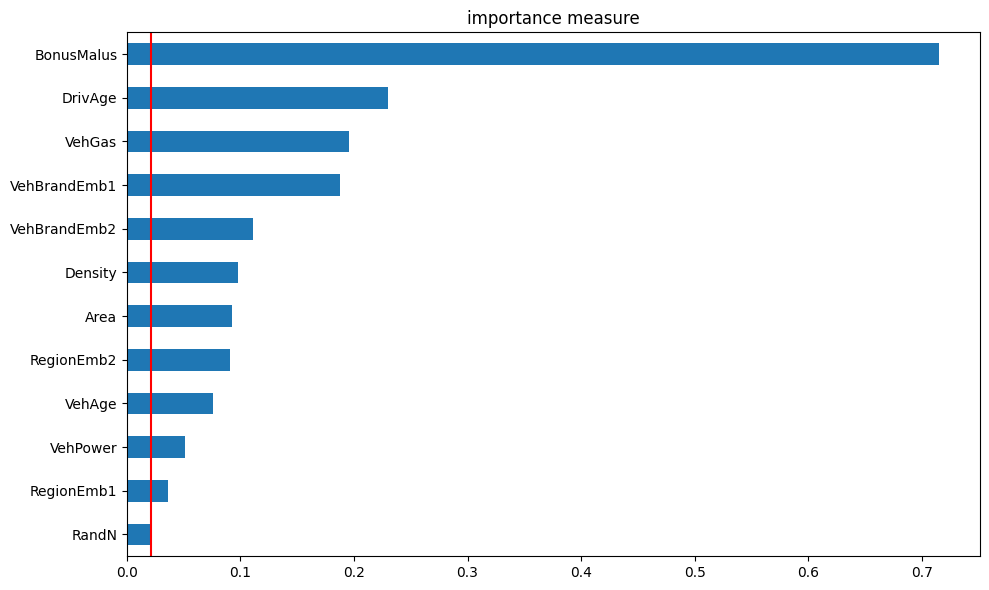

In [20]:
# Calculate importance measure
vi = np.abs(attention_df).mean()
vi = vi.sort_values()

# Plot importance measure
plt.figure(figsize=(10, 6))
vi.plot(kind="barh")
# Add vertical line for AreaX importance
area_importance = vi["RandN"]
plt.axvline(x=area_importance, color="red", linestyle="-", label="RandN importance")
plt.title("importance measure")
plt.tight_layout()
plt.show()

### Plot individual attention weights for selected variables

In [21]:
# Function to create individual attention weight plots
def plot_attention_weights(feature_name, alpha):
    # Get unique values for x-axis
    x_values = np.sort(test[feature_name].unique())

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot the attention weights
    plt.scatter(
        test[feature_name],
        attention_df[feature_name],
        alpha=0.5,
        s=20,
        label="attention weights",
    )

    # Add reference lines
    plt.axhline(y=0, color="cyan", linestyle="-", label="zero line")
    plt.axhline(
        y=0.674 * randnx_std,
        color="orange",
        linestyle="-",
        label="0.674 std.dev. (50%)",
    )
    plt.axhline(y=-0.674 * randnx_std, color="orange", linestyle="-")
    plt.axhline(
        y=2.576 * randnx_std, color="red", linestyle="-", label="2.576 std.dev. (99%)"
    )
    plt.axhline(y=-2.576 * randnx_std, color="red", linestyle="-")

    # Add shaded area
    plt.fill_between(
        [test[feature_name].min(), test[feature_name].max()],
        [-0.674 * randnx_std, -0.674 * randnx_std],
        [0.674 * randnx_std, 0.674 * randnx_std],
        color="orange",
        alpha=0.3,
    )

    # Add local regression fit
    from statsmodels.nonparametric.smoothers_lowess import lowess

    # Sort the data for local regression
    sorted_indices = np.argsort(test[feature_name])
    x_sorted = test[feature_name].iloc[sorted_indices]
    y_sorted = attention_df[feature_name].iloc[sorted_indices]

    # Fit local regression
    lowess_fit = lowess(y_sorted, x_sorted, frac=alpha, it=3)

    # Plot the local regression fit
    plt.plot(
        lowess_fit[:, 0],
        lowess_fit[:, 1],
        color="lightgreen",
        label="local regression fit",
    )

    # Customize the plot
    plt.title(f"attention weights: {feature_name}", fontsize=14)
    plt.xlabel(feature_name, fontsize=12)
    plt.ylabel("attention weights", fontsize=12)
    plt.legend(loc="lower right")

    # Set y-axis limits
    # ylim0 = max(abs(attention_df[feature_name]))
    ylim0 = np.max(np.abs(attention_df))
    plt.ylim(-ylim0, ylim0)

    plt.tight_layout()
    plt.show()


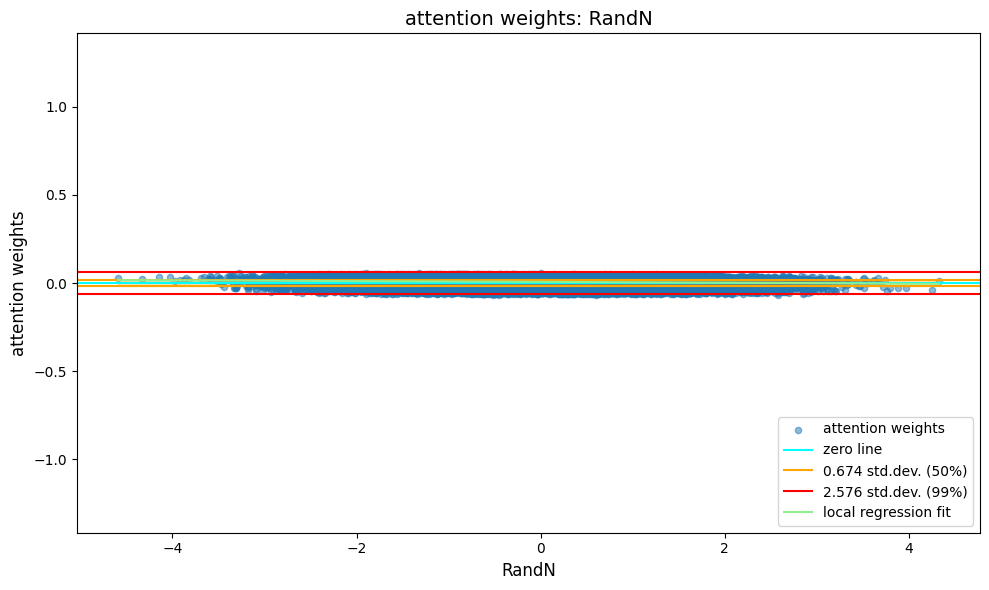

In [22]:
# This is the purely random variable not impacting the response
# we perform a local regression which is a bit time consuming
plot_attention_weights("RandN", 0.3)

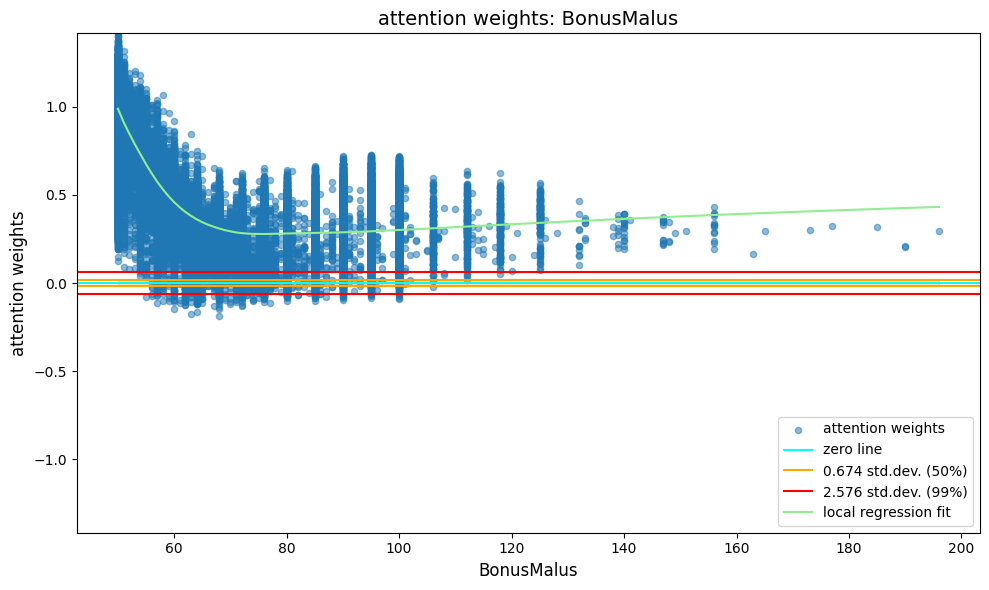

In [23]:
# BonusMalus is the most significant term
# the local regression is not fully sensible because BonusMalus values cluster at the lowest level
plot_attention_weights("BonusMalus", 0.6)

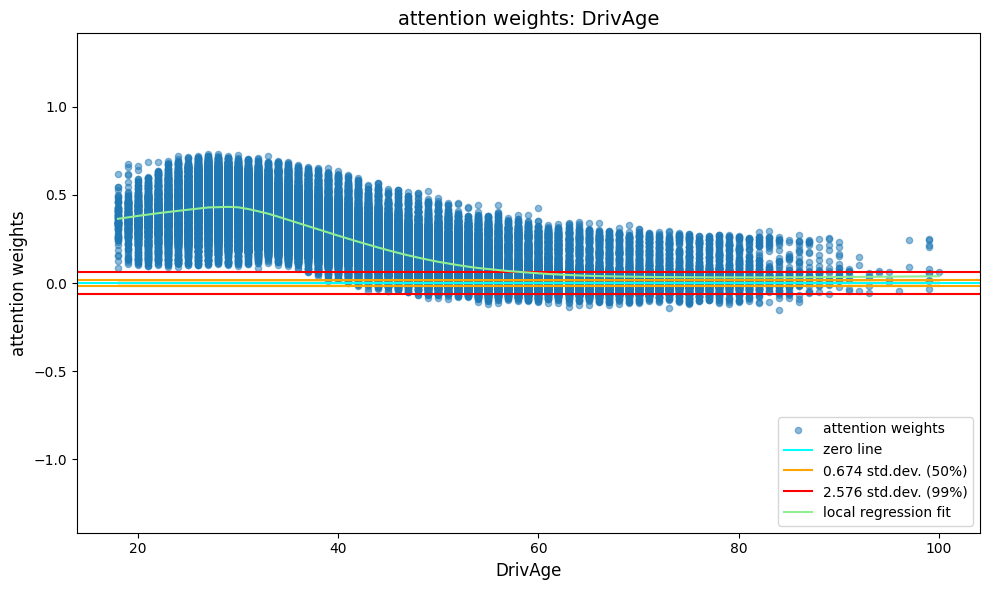

In [24]:
# Driver age variabel
plot_attention_weights("DrivAge", 0.3)